## 1. Imports & settings
Standard imports, plotting style, and helper functions. Keep this section minimal and well-commented.

In [1]:

# Basic setup and imports
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


# ML imports
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib

# Helpers
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def load_csv(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    return pd.read_csv(path)


## 2. Load dataset
Load the historical prices and info CSVs. Print shape and sample rows.

In [2]:
import pandas as pd  
hist = pd.read_csv("Coca-Cola_stock_history.csv")  
info = pd.read_csv("Coca-Cola_stock_info.csv")  


### 2.1 Basic cleaning & parse dates
Make sure `Date` is datetime, sort the data, convert numeric columns, and forward-fill missing values where appropriate.

In [3]:

# Ensure Date column exists (try common names)
date_col = next((c for c in hist.columns if 'date' in c.lower()), None)
if date_col is None:
    raise ValueError("No date column found in history CSV")
hist[date_col] = pd.to_datetime(hist[date_col], errors='coerce')
hist = hist.sort_values(by=date_col).reset_index(drop=True)

# Standardize column names to simple ones
col_map = {}
for c in hist.columns:
    lc = c.lower()
    if 'open' in lc:
        col_map[c] = 'Open'
    elif 'high' in lc:
        col_map[c] = 'High'
    elif 'low' in lc:
        col_map[c] = 'Low'
    elif 'close' in lc:
        col_map[c] = 'Close'
    elif 'volume' in lc:
        col_map[c] = 'Volume'
    elif 'dividend' in lc:
        col_map[c] = 'Dividends'
    elif 'split' in lc:
        col_map[c] = 'Stock_Splits'
# apply renaming
hist = hist.rename(columns=col_map)

# Ensure numeric types for price columns
for c in ['Open','High','Low','Close','Volume','Dividends','Stock_Splits']:
    if c in hist.columns:
        hist[c] = pd.to_numeric(hist[c], errors='coerce')

# Forward-fill to maintain continuity (common for stock data)
hist = hist.fillna(method='ffill').fillna(method='bfill')
hist = hist.dropna(subset=['Close']).reset_index(drop=True)

# set Date as index for convenience in some plots
hist.set_index(date_col, inplace=True)
hist.index.name = 'Date'

print("After cleaning, shape:", hist.shape)
hist.head()


After cleaning, shape: (15311, 7)


,Open,High,Low,Close,Volume,Dividends,Stock_Splits
Date,,,,,,,
1962-01-02,0.050016,0.051378,0.050016,0.050016,806400,0.0,0
1962-01-03,0.049273,0.049273,0.048159,0.048902,1574400,0.0,0
1962-01-04,0.049026,0.049645,0.049026,0.049273,844800,0.0,0
1962-01-05,0.049273,0.049892,0.048035,0.048159,1420800,0.0,0
1962-01-08,0.047787,0.047787,0.046735,0.047664,2035200,0.0,0


## 3. Exploratory Data Analysis (EDA)
Plot price history, moving averages and distribution of returns. Keep visuals simple and explanatory.

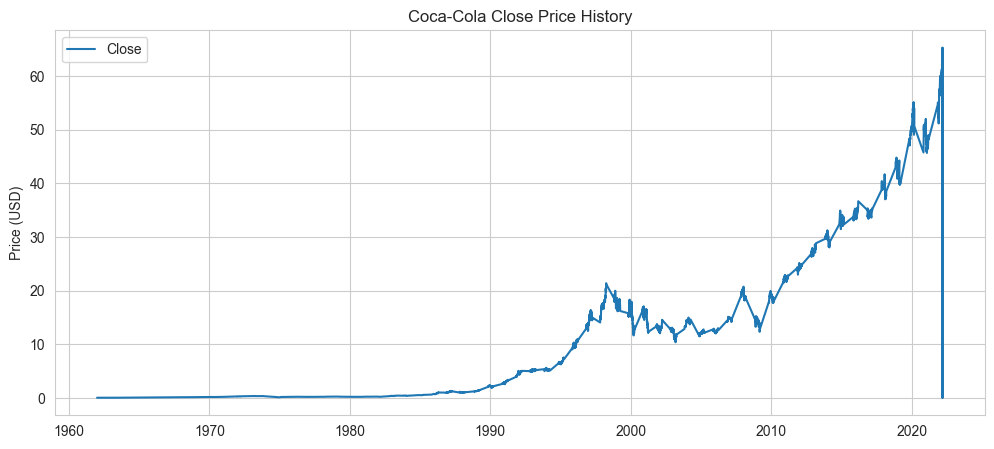

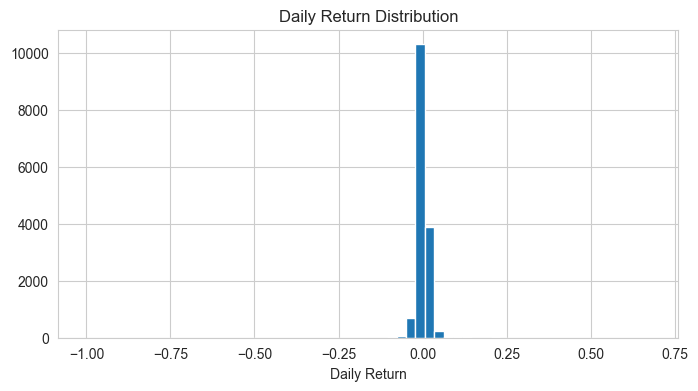

count    15311.000000
mean        11.815409
std         15.026316
min          0.037028
25%          0.238312
50%          4.937339
75%         17.415106
max         65.259270
Name: Close, dtype: float64

count    15311.000000
mean         0.001077
std          0.022687
min         -0.999186
25%         -0.006818
50%          0.000000
75%          0.007731
max          0.677367
Name: Daily_Return, dtype: float64

In [4]:

# Plot Close price history
plt.figure(figsize=(12,5))
plt.plot(hist['Close'], label='Close')
plt.title('Coca-Cola Close Price History')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Compute returns and show distribution
hist['Daily_Return'] = hist['Close'].pct_change().fillna(0)
plt.figure(figsize=(8,4))
plt.hist(hist['Daily_Return'], bins=60)
plt.title('Daily Return Distribution')
plt.xlabel('Daily Return')
plt.show()

# Show basic stats
display(hist['Close'].describe())
display(hist['Daily_Return'].describe())


## 4. Feature engineering
Create technical indicators: moving averages, volatility, lag features, and target (next-day Close).

In [5]:

# Moving averages
hist['MA_20'] = hist['Close'].rolling(window=20).mean()
hist['MA_50'] = hist['Close'].rolling(window=50).mean()
hist['MA_200'] = hist['Close'].rolling(window=200).mean()

# Exponential moving averages
hist['EMA_12'] = hist['Close'].ewm(span=12, adjust=False).mean()
hist['EMA_26'] = hist['Close'].ewm(span=26, adjust=False).mean()

# Volatility (rolling std of returns)
hist['Volatility_20'] = hist['Daily_Return'].rolling(window=20).std() * np.sqrt(20)

# Momentum indicators: simple differences
hist['Return_1'] = hist['Close'].pct_change(periods=1)
hist['Return_5'] = hist['Close'].pct_change(periods=5)
hist['Return_10'] = hist['Close'].pct_change(periods=10)

# Lag features (previous day's close etc.)
hist['Close_lag_1'] = hist['Close'].shift(1)
hist['Close_lag_2'] = hist['Close'].shift(2)
hist['Close_lag_3'] = hist['Close'].shift(3)

# Target: next-day Close (we'll predict Close_{t+1})
hist['Target_Close_next'] = hist['Close'].shift(-1)

# Drop rows with NaNs (due to rolling / shifting)
hist_feat = hist.dropna().copy()
print("Feature dataset shape:", hist_feat.shape)
hist_feat.head()


Feature dataset shape: (15111, 21)


,Open,High,Low,Close,Volume,Dividends,Stock_Splits,Daily_Return,MA_20,MA_50,...,EMA_12,EMA_26,Volatility_20,Return_1,Return_5,Return_10,Close_lag_1,Close_lag_2,Close_lag_3,Target_Close_next
Date,,,,,,,,,,,,,,,,,,,,,
1963-04-18,0.048422,0.048550,0.048422,0.048486,768000,0.0,0,0.002653,0.048191,0.047722,...,0.048351,0.048078,0.019302,0.002653,0.005319,0.003987,0.048358,0.048615,0.048615,0.048486
1963-04-19,0.048486,0.048807,0.048486,0.048486,2764800,0.0,0,0.000000,0.048223,0.047751,...,0.048372,0.048108,0.019206,0.000000,0.000000,0.000000,0.048486,0.048358,0.048615,0.048615
1963-04-22,0.048486,0.048615,0.048166,0.048615,652800,0.0,0,0.002645,0.048262,0.047791,...,0.048409,0.048146,0.019290,0.002645,0.000000,0.006642,0.048486,0.048486,0.048358,0.048743
1963-04-23,0.048615,0.049192,0.048550,0.048743,2112000,0.0,0,0.002639,0.048313,0.047831,...,0.048461,0.048190,0.019009,0.002639,0.002639,0.009298,0.048615,0.048486,0.048486,0.048486
1963-04-24,0.048743,0.048935,0.048486,0.048486,1574400,0.0,0,-0.005262,0.048355,0.047850,...,0.048465,0.048212,0.019915,-0.005262,0.002653,0.005319,0.048743,0.048615,0.048486,0.048165


### 4.1 Plot indicators (MA & Volatility)

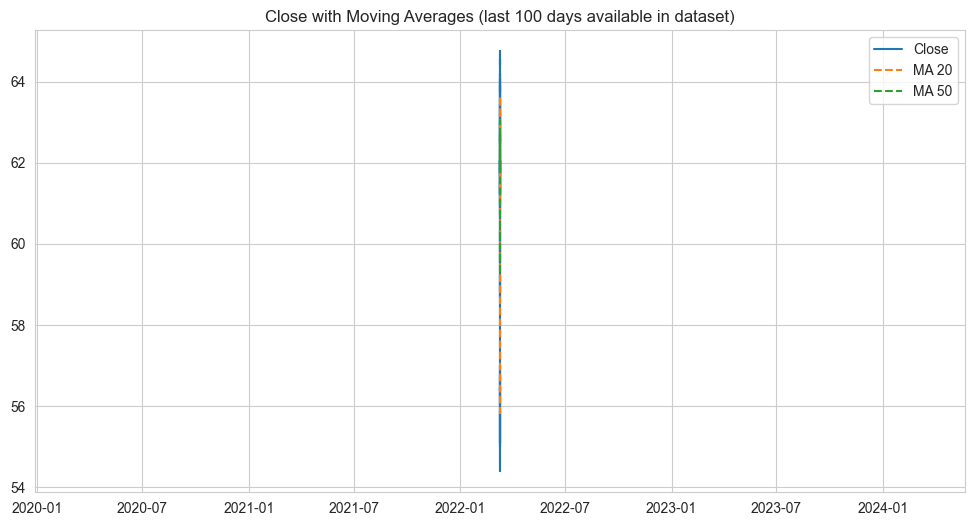

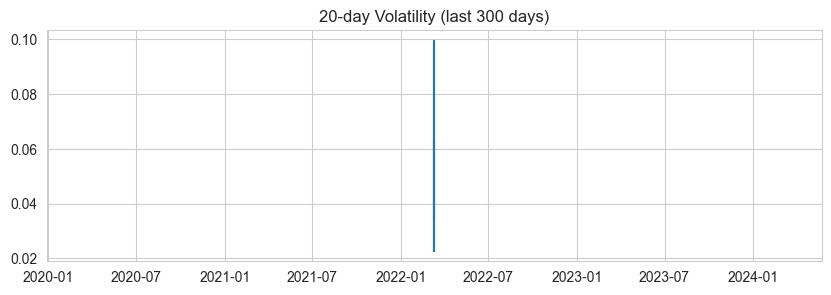

In [6]:

plt.figure(figsize=(12,6))
plt.plot(hist_feat['Close'][-100:], label='Close')
plt.plot(hist_feat['MA_20'][-100:], label='MA 20', linestyle='--')
plt.plot(hist_feat['MA_50'][-100:], label='MA 50', linestyle='--')
plt.title('Close with Moving Averages (last 100 days available in dataset)')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(hist_feat['Volatility_20'][-300:])
plt.title('20-day Volatility (last 300 days)')
plt.show()


## 5. Prepare data for modeling
Select features, perform time-series train/test split (no shuffling), scale numeric features, and save feature order.

In [7]:

# Features to use (choose meaningful ones)
FEATURES = [
    'Close', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3',
    'MA_20', 'MA_50', 'MA_200', 'EMA_12', 'EMA_26',
    'Volatility_20', 'Return_1', 'Return_5', 'Return_10', 'Volume'
]

# Keep only columns that exist (some datasets may lack Volume)
FEATURES = [f for f in FEATURES if f in hist_feat.columns]
TARGET = 'Target_Close_next'

X = hist_feat[FEATURES].copy()
y = hist_feat[TARGET].copy()

print("Using features:", FEATURES)
print("X shape, y shape:", X.shape, y.shape)

# Time-series split: last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Save feature order for deployment
with open('feature_order.json', 'w') as f:
    json.dump(FEATURES, f)


Using features: ['Close', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'MA_20', 'MA_50', 'MA_200', 'EMA_12', 'EMA_26', 'Volatility_20', 'Return_1', 'Return_5', 'Return_10', 'Volume']
X shape, y shape: (15111, 14) (15111,)
Train shape: (12088, 14) Test shape: (3023, 14)


## 6. Modeling
Train two baseline models (Random Forest and Gradient Boosting). We'll use a simple scaler in a pipeline and save the best model.

In [8]:
# Preprocessing: scale numeric features (all are numeric here)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, FEATURES)], remainder='drop')

# Pipelines
rf_pipeline = Pipeline(steps=[('pre', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1))])

gbr_pipeline = Pipeline(steps=[('pre', preprocessor),
                               ('model', GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42))])

# Fit Random Forest
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)
print("RF trained.")

# Fit Gradient Boosting
print("Training Gradient Boosting...")
gbr_pipeline.fit(X_train, y_train)
print("GBR trained.")

# Evaluate helper
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
rmse = lambda y, y_pred: mean_squared_error(y, y_pred) ** 0.5


def evaluate(pipeline, X_tr, y_tr, X_te, y_te, name='model'):
    y_tr_pred = pipeline.predict(X_tr)
    y_te_pred = pipeline.predict(X_te)
    print(f"--- {name} ---")
    print("Train RMSE:", rmse(y_tr, y_tr_pred))
    print("Test  RMSE:", rmse(y_te, y_te_pred))
    print("Test  MAE:", mean_absolute_error(y_te, y_te_pred))
    print("Test  R2:", r2_score(y_te, y_te_pred))
    return y_te_pred

rf_pred = evaluate(rf_pipeline, X_train, y_train, X_test, y_test, 'RandomForest')
gbr_pred = evaluate(gbr_pipeline, X_train, y_train, X_test, y_test, 'GradientBoosting')

# Choose best model by Test RMSE
rf_rmse = rmse(y_test, rf_pred)
gbr_rmse = rmse(y_test, gbr_pred)
best_name = 'RandomForest' if rf_rmse < gbr_rmse else 'GradientBoosting'
best_pipeline = rf_pipeline if best_name == 'RandomForest' else gbr_pipeline
print(f"Selected best model: {best_name}")

# Save best model and preprocessor
import joblib
joblib.dump(best_pipeline, 'best_model_pipeline.pkl')
print("Saved best_model_pipeline.pkl")


Training Random Forest...
RF trained.
Training Gradient Boosting...
GBR trained.
--- RandomForest ---
Train RMSE: 0.22650052493137898
Test  RMSE: 4.728839643149355
Test  MAE: 1.5742023789970674
Test  R2: 0.8831624065905961
--- GradientBoosting ---
Train RMSE: 0.18570957324100063
Test  RMSE: 9.32481101537794
Test  MAE: 2.5838719562954453
Test  R2: 0.5456887344432464
Selected best model: RandomForest
Saved best_model_pipeline.pkl
